In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


Import data

In [ ]:
usecols = ['id', 'name', 'cleaned_abilities', 'cleaned_rules', 'cleaned_attacks', 'hp', 'types', 'subtypes', 'evolvesFrom', 'evolvesTo', 'weaknesses', 'convertedRetreatCost', 'resistances']
standard_2021_synergies = pd.read_csv('/content/drive/MyDrive/266/project/standard_2021_synergies.csv')
standard_2022_synergies = pd.read_csv('/content/drive/MyDrive/266/project/standard_2022_synergies.csv')
standard_2023_synergies = pd.read_csv('/content/drive/MyDrive/266/project/standard_2023_synergies.csv')



In [ ]:
dat = pd.concat([standard_2021_synergies, standard_2022_synergies, standard_2023_synergies], axis=0).fillna(0)
standard_2021_synergies_padded = dat.iloc[:standard_2021_synergies.shape[0], :]
standard_2022_synergies_padded = dat.iloc[standard_2021_synergies.shape[0]:standard_2021_synergies.shape[0]+standard_2022_synergies.shape[0], :]
standard_2023_synergies_padded = dat.iloc[standard_2021_synergies.shape[0]+standard_2022_synergies.shape[0]:, :]

In [ ]:
card_counts = dat['id'].nunique()

In [ ]:
assert(standard_2021_synergies_padded.shape[0]==standard_2021_synergies.shape[0])
assert(standard_2022_synergies_padded.shape[0]==standard_2022_synergies.shape[0])
assert(standard_2023_synergies_padded.shape[0]==standard_2023_synergies.shape[0])

assert(standard_2021_synergies_padded.shape[1]==standard_2023_synergies_padded.shape[1])
assert(standard_2022_synergies_padded.shape[1]==standard_2023_synergies_padded.shape[1])

In [ ]:
train_dat_x = pd.concat([
    standard_2021_synergies_padded[usecols],
    standard_2022_synergies_padded[usecols]],
axis=0).apply(lambda row: ';'.join([str(elem) for elem in row]), axis=1).to_numpy()
test_dat_x = standard_2023_synergies_padded[usecols].apply(lambda row: ';'.join([str(elem) for elem in row]), axis=1).to_numpy()

train_dat_y = pd.concat([
    standard_2021_synergies_padded.iloc[:, -card_counts:],
    standard_2022_synergies_padded.iloc[:, -card_counts:]],
axis=0)
test_dat_y = standard_2023_synergies_padded.iloc[:, -card_counts:]

Define tokenizer

In [ ]:
max_length = 512

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_train_x = tokenizer(
    train_dat_x.tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
    return_tensors='tf'
)

tokenized_test_x = tokenizer(
    test_dat_x.tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
    return_tensors='tf'
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Define BERT model

In [ ]:
# https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#transformers.TFBertModel

bert_model = TFBertModel.from_pretrained("bert-base-uncased", output_hidden_states=True, output_attentions=True)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Optionally freeze layers

In [ ]:
# Freeze layers
bert_model.bert.encoder.trainable = True
bert_model.bert.embeddings.trainable = True

Define the model

In [ ]:
def stack_layers(hidden_states):
    stacked = tf.stack(hidden_states, axis=0)  # Shape: (n, batch_size, seq_length, hidden_size)
    return tf.reduce_mean(stacked, axis=2)  # Average over sequence tokens, shape: (n, batch_size, hidden_size)

def reshape_layers(tensor):
    transposed = tf.transpose(tensor, perm=[1, 0, 2])  # Shape: (batch_size, n, hidden_size)
    batch_size = tf.shape(transposed)[0]
    reshaped_dim = embedding_nlayers * 768
    return tf.reshape(transposed, [batch_size, reshaped_dim])  # Shape: (batch_size, n*hidden_size)

In [ ]:
# Create model
embedding_nlayers = 3

input_ids = keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = keras.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
token_type_ids = keras.Input(shape=(max_length,), dtype=tf.int32, name="token_type_ids")

bert_outputs = bert_model.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

hidden_states = bert_outputs.pooler_output
dropout_1_out = keras.layers.Dropout(0.1)(hidden_states)
linear_1_out = keras.layers.Dense(256, activation='relu')(dropout_1_out)
layer_norm_1_out = keras.layers.LayerNormalization()(linear_1_out)
dropout_2_out = keras.layers.Dropout(0.1)(layer_norm_1_out)
linear_2_out = keras.layers.Dense(64, activation='relu')(dropout_2_out)
out = keras.layers.Dense(card_counts, activation='sigmoid')(linear_2_out)

model = keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                              

Train

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

history = model.fit(
    x=dict(tokenized_train_x),
    y=train_dat_y,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
)

Epoch 1/10
68/68 [==============================] - 165s 2s/step - loss: 0.1083 - accuracy: 0.0153 - val_loss: 0.0205 - val_accuracy: 0.1611
Epoch 2/10
68/68 [==============================] - 118s 2s/step - loss: 0.0084 - accuracy: 0.0218 - val_loss: 0.0196 - val_accuracy: 0.0611
Epoch 3/10
68/68 [==============================] - 138s 2s/step - loss: 0.0083 - accuracy: 0.0227 - val_loss: 0.0189 - val_accuracy: 0.1426
Epoch 4/10
68/68 [==============================] - 138s 2s/step - loss: 0.0081 - accuracy: 0.0181 - val_loss: 0.0179 - val_accuracy: 0.0815
Epoch 5/10
68/68 [==============================] - 138s 2s/step - loss: 0.0079 - accuracy: 0.0153 - val_loss: 0.0182 - val_accuracy: 0.0630
Epoch 6/10
68/68 [==============================] - 138s 2s/step - loss: 0.0078 - accuracy: 0.0218 - val_loss: 0.0189 - val_accuracy: 0.0815
Epoch 7/10
68/68 [==============================] - 138s 2s/step - loss: 0.0077 - accuracy: 0.0218 - val_loss: 0.0187 - val_accuracy: 0.1611
Epoch 8/10
68

In [ ]:
bert_model_filename = "synergy_dense_bert_v1"
model_filename = "synergy_dense_model.keras_v1"

# bert_model.save_pretrained(f"/content/drive/MyDrive/266/project/{bert_model_filename}")
# model.save(f"/content/drive/MyDrive/266/project/{model_filename}")
bert_model = TFBertModel.from_pretrained(f"/content/drive/MyDrive/266/project/{bert_model_filename}")
loaded_model = keras.saving.load_model(f"/content/drive/MyDrive/266/project/{model_filename}")

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at /content/drive/MyDrive/266/project/synergy_dense_bert_v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
preds = loaded_model.predict(dict(tokenized_test_x))


53/53 [==============================] - 70s 1s/step


Extract correct columns

In [ ]:
test_synergies = standard_2023_synergies_padded.iloc[:, -card_counts:]
just_2023_columns = test_synergies.columns.isin(standard_2023_synergies_padded['id'])
test_synergies_just_2023 = test_synergies.loc[:, just_2023_columns]
preds_just_2023 = preds[:, just_2023_columns]

assert(test_synergies_just_2023.shape == preds_just_2023.shape)

In [ ]:
differences = test_synergies_just_2023-preds_just_2023
differences.index = differences.columns
differences

,sm12-97,swshp-SWSH108,swshp-SWSH115,swsh2-151,swsh5-6,swsh5-21,swsh5-22,swsh5-87,swsh5-88,swsh6-80,...,sv2-184,sv2-185,sv3-189,sv3-192,sv3-193,sv3-196,sv3-197,sv3pt5-153,sv3pt5-160,sv3pt5-162
sm12-97,-0.001853,-0.000582,-0.000733,-0.000036,-0.001190,-0.000363,-0.000801,-0.004311,-0.003038,-0.001834,...,-0.000004,0.512599,-0.000005,0.042006,0.004196,0.004191,-0.000007,-0.000004,-0.000003,-0.000004
swshp-SWSH108,-0.002219,-0.000744,-0.000934,-0.000043,-0.001458,-0.000454,-0.001048,-0.005415,-0.003659,-0.002393,...,-0.000004,-0.000006,-0.000006,-0.000012,-0.000006,-0.000013,-0.000008,-0.000005,-0.000004,-0.000005
swshp-SWSH115,-0.020975,-0.016933,-0.044625,0.026929,-0.020259,-0.019255,-0.042385,-0.078398,-0.049507,-0.105441,...,-0.000099,0.194359,-0.000103,-0.000091,-0.000089,0.027637,-0.000091,-0.000085,-0.000073,-0.000087
swsh2-151,-0.002309,-0.000847,-0.001060,-0.000043,-0.001653,-0.000503,-0.001205,-0.006442,-0.003784,-0.002613,...,0.003505,0.554380,-0.000006,0.035076,0.003503,0.007005,-0.000007,-0.000005,-0.000004,-0.000005
swsh5-6,-0.003257,-0.001396,-0.001780,-0.000064,-0.002598,-0.000814,-0.002056,-0.010416,-0.005305,-0.004212,...,-0.000006,-0.000008,-0.000008,-0.000016,-0.000007,-0.000018,-0.000010,-0.000006,-0.000005,-0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sv3-196,-0.013343,-0.009622,-0.024222,-0.000395,-0.012511,-0.009937,-0.023190,-0.053312,-0.029970,-0.057811,...,-0.000042,0.399961,-0.000047,-0.000045,-0.000041,-0.000066,0.039958,-0.000038,-0.000033,-0.000037
sv3-197,-0.010284,-0.006978,-0.015382,-0.000266,-0.009534,-0.006384,-0.015295,-0.041768,-0.022021,-0.036920,...,-0.000027,0.909065,-0.000032,0.090875,-0.000027,0.090862,-0.000029,-0.000025,-0.000022,-0.000025
sv3pt5-153,-0.019872,-0.015834,-0.042602,-0.000770,-0.019071,-0.018186,-0.040241,-0.074921,-0.047020,-0.100783,...,-0.000088,0.999923,-0.000092,-0.000081,-0.000081,-0.000126,-0.000083,-0.000077,-0.000066,0.999923
sv3pt5-160,0.322600,-0.007338,-0.016519,-0.000284,-0.009954,-0.006847,-0.016362,-0.043473,-0.023129,-0.039729,...,-0.000029,0.999972,-0.000034,0.333298,-0.000029,-0.000050,-0.000031,-0.000026,-0.000023,-0.000026


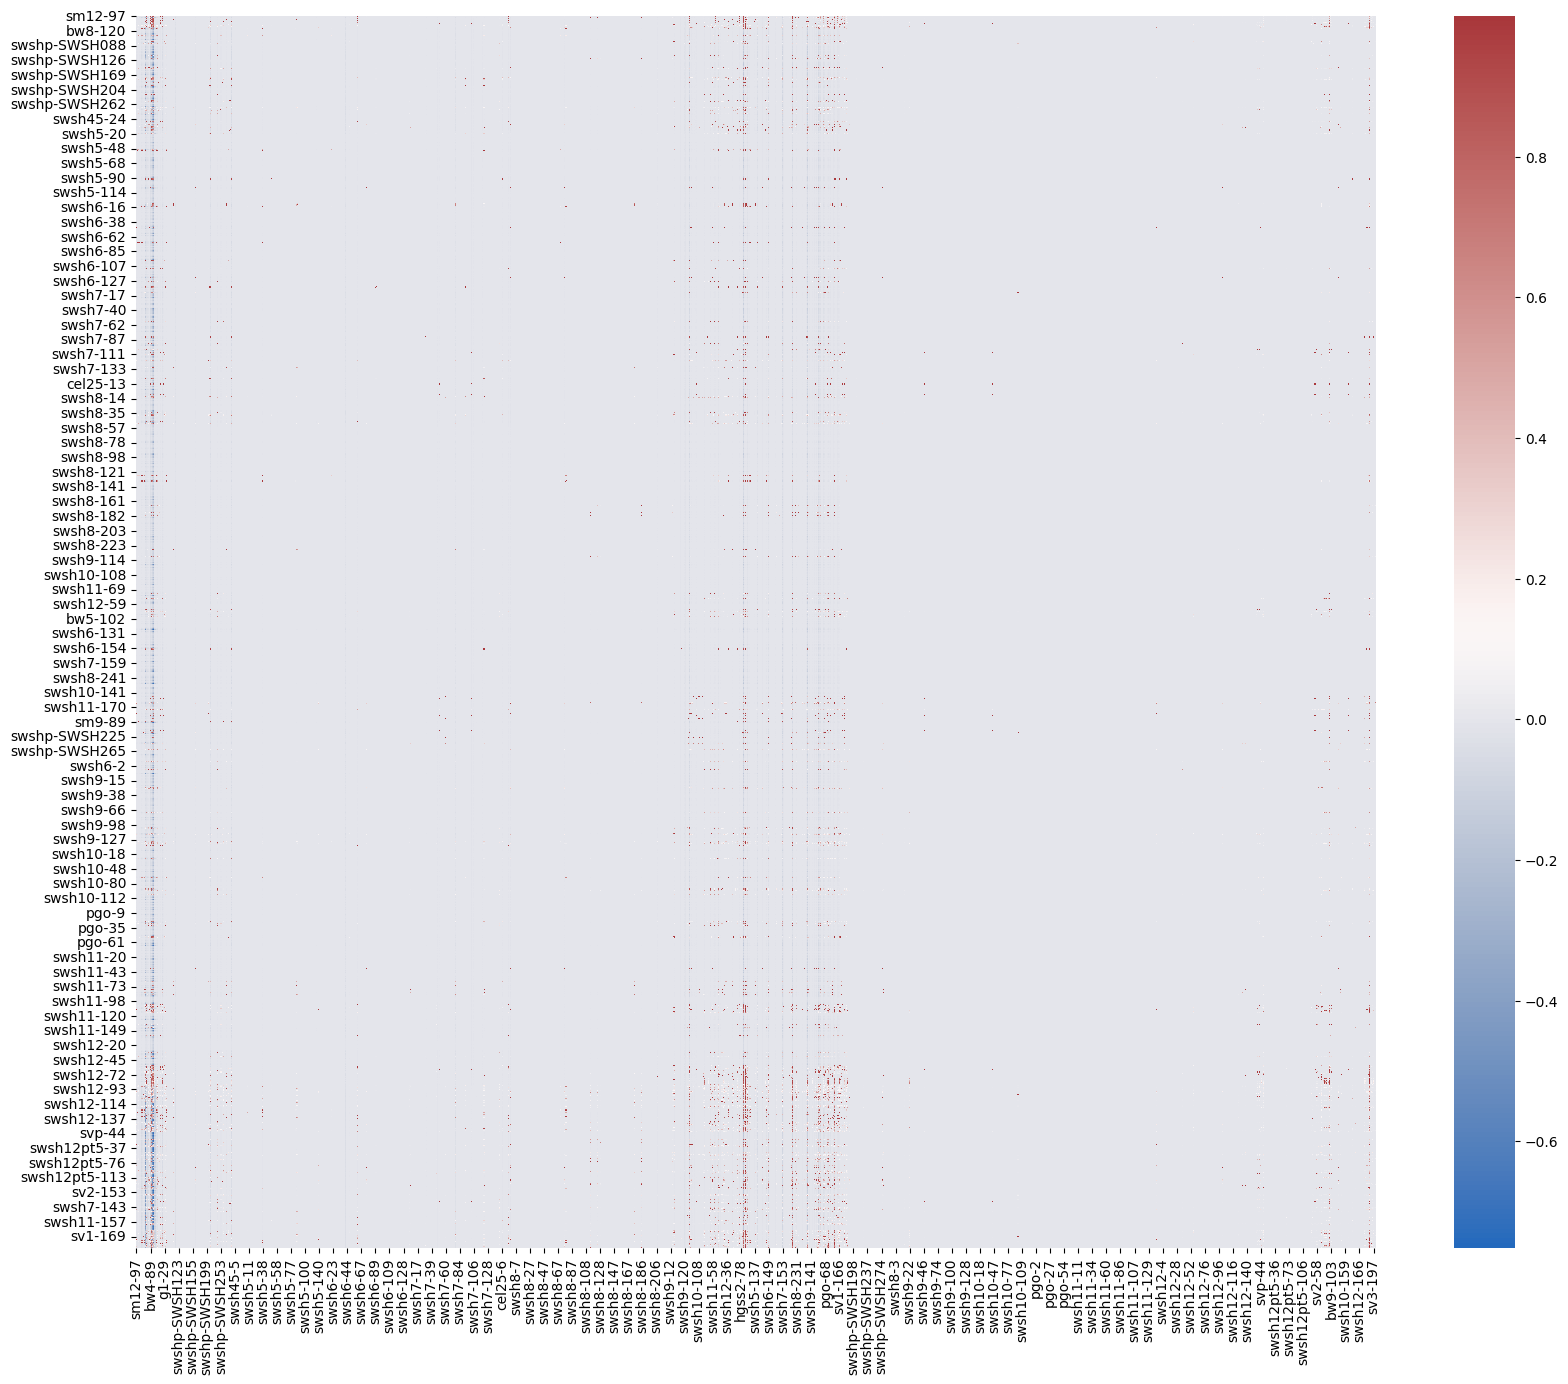

In [ ]:
fig = plt.figure(figsize=(20, 16))
sns.heatmap(differences, annot=False, cmap='vlag')
plt.show()

Top 10 true synergies

In [ ]:
def get_top_n_indices(data, n):
  data = np.array(data)
  top_n_values = sorted(np.unique(test_synergies_just_2023.to_numpy().flatten()))[-n:]
  data_mask = data > top_n_values[0]
  ret_rows = set([])
  ret_cols = set([])
  counter = 0
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      if data_mask[i, j]:
        ret_rows.add(i)
        ret_cols.add(j)
  return ret_rows, ret_cols


In [ ]:
rows, cols = get_top_n_indices(test_synergies_just_2023, 10)

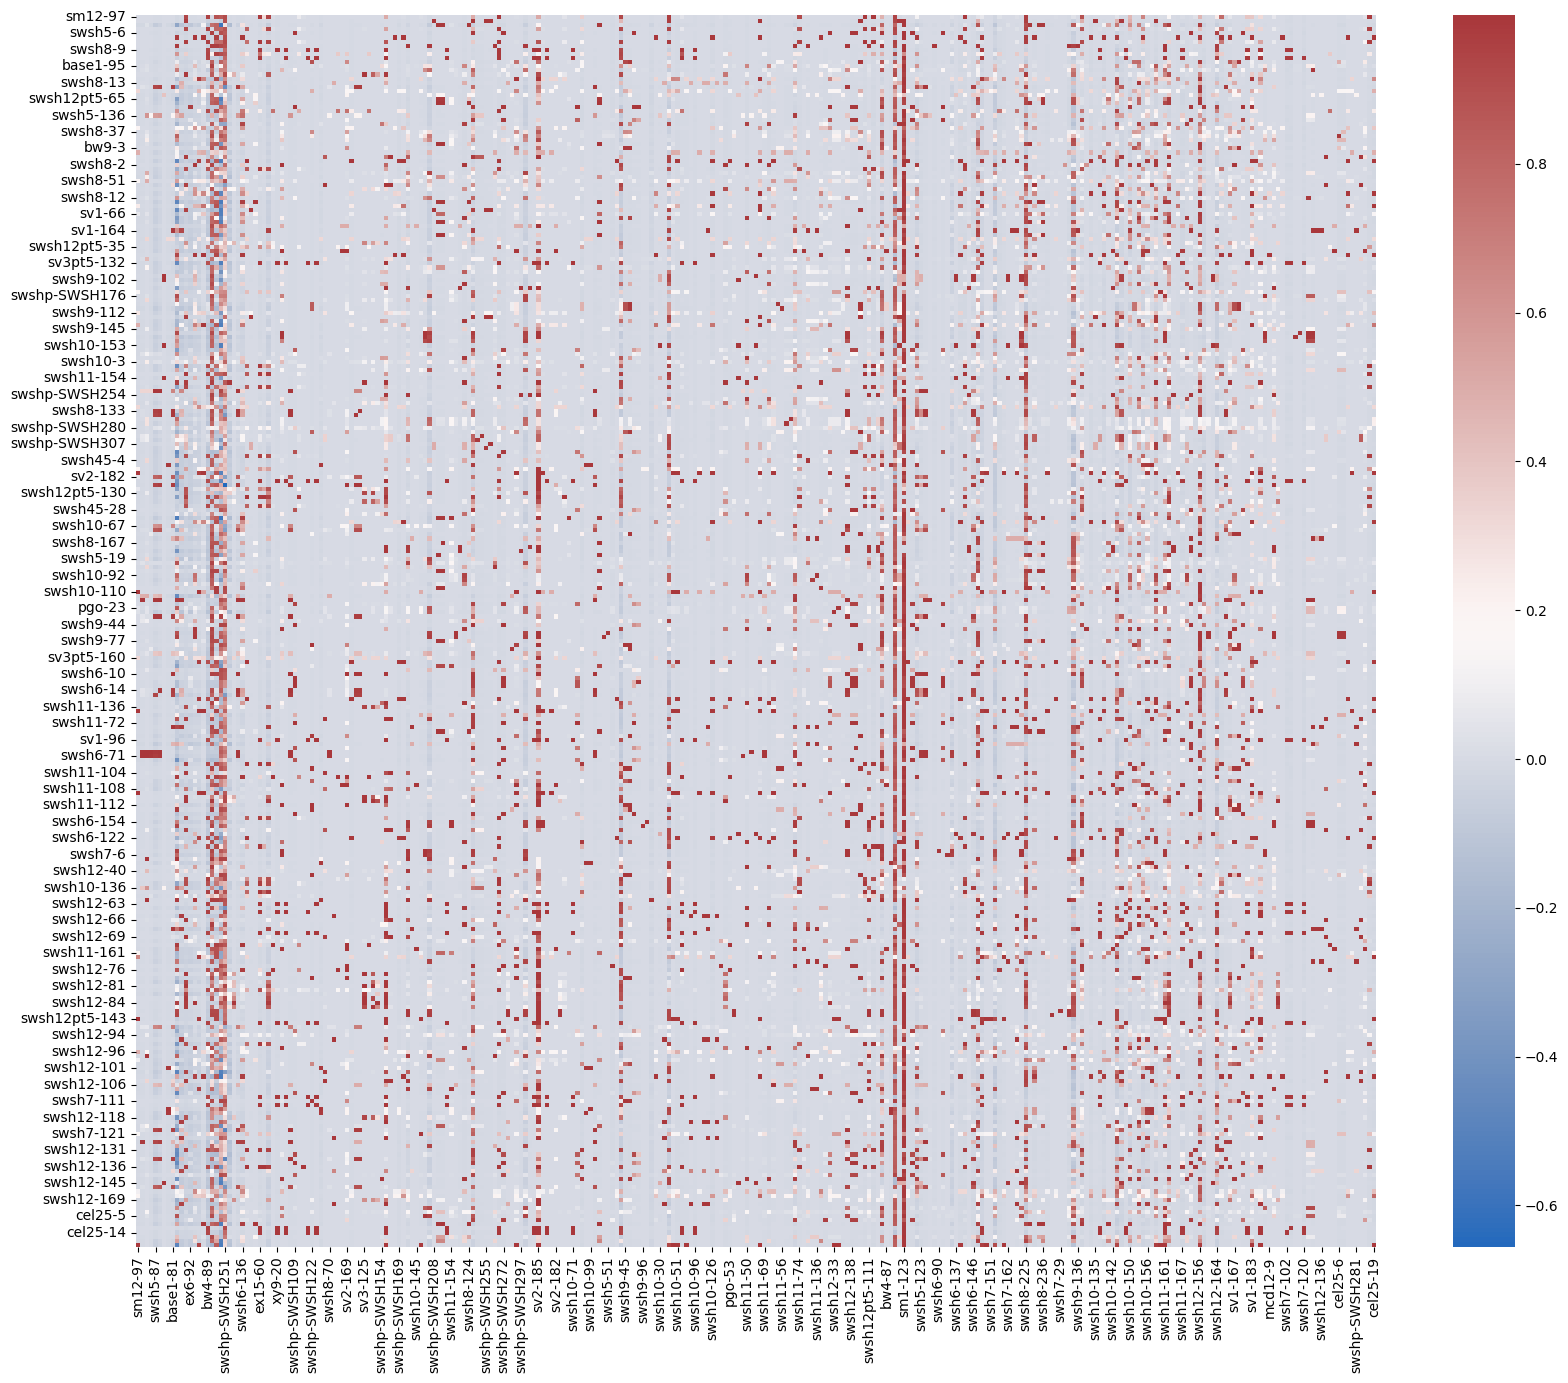

In [ ]:
fig = plt.figure(figsize=(20, 16))
sns.heatmap(differences.iloc[list(rows), list(cols)], annot=False, cmap='vlag')
plt.show()

In [ ]:
n = 10
lowest_n_values = sorted(np.unique(differences.to_numpy().flatten()))[:n]
mask = differences <= lowest_n_values[-1]
synergies = []
for card1 in differences.index:
  for card2 in differences.columns:
    if mask.loc[card1, card2]:
      print(card1, card2)
      synergies.append((card1, card2))
      if len(synergies) == n:
        break
  if len(synergies) == n:
        break

swshp-SWSH242 swshp-SWSH251
swsh45-20 swshp-SWSH251
swsh5-133 swshp-SWSH251
svp-53 swshp-SWSH251
swsh12pt5-32 swshp-SWSH251
swsh12pt5-42 swshp-SWSH251
swsh12pt5-106 swshp-SWSH251
sv2-18 swshp-SWSH251
sv2-71 swshp-SWSH251
swsh10-158 swshp-SWSH251


In [ ]:
mask.sum().sum()

np.int64(0)